This notebook is comparable to rays_pitchers_positioning only I have a parameter team number that I use to set the team whose pitchers I am defining posiitoning for. Then I use this notebook to do positioning for all 30 teams instead of just the Rays in parallel by changing the parameter team number in the job specification

In [0]:
#the team number parameter from the databricks job

try: 
    team_num = int(dbutils.widgets.get("team_num"))
except:
    team_num = 8
    print('Testing Mode')

Testing Mode


In [0]:
import pandas as pd
import numpy as np
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.stats import norm, gamma, beta, bernoulli
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, HistGradientBoostingClassifier
import scipy.special as sc
import math
import pickle
import gc
import warnings
warnings.filterwarnings("ignore")

/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Sampling

In [0]:
#read in the field dims
field_dims = pd.read_csv('../data/field_dims.csv')


raw23 = pd.read_csv('../data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']
raw23 = raw23.loc[raw23.game_date > '2023-03-29'] #only regular season games

In [0]:
#define the teams in a fixed, consistent order 
teams = ['AZ', 'TEX', 'PHI', 'HOU', 'MIN', 'ATL', 'LAD', 'BAL', 'TB', 'MIL',
       'LAA', 'SF', 'PIT', 'DET', 'SEA', 'COL', 'TOR', 'CWS', 'NYM',
       'STL', 'KC', 'BOS', 'CLE', 'NYY', 'WSH', 'CIN', 'CHC', 'MIA', 'SD',
       'OAK']

team = teams[team_num]

In [0]:
#only get the matchups for the team of interest. The dataframe is named rays just because I copied and pasted from the Rays notebook, but it isn't necessarily the Rays
rays = raw23.loc[(raw23.home_team == team) | (raw23.away_team == team)]
rays['rays_pitching'] = 0 #again, this column is called rays_pitching because I copy and pasted. It should really be called team_pitching
rays.loc[(rays.home_team == team) & (rays.inning_topbot == 'Top'), 'rays_pitching'] = 1
rays.loc[(rays.away_team == team) & (rays.inning_topbot == 'Bot'), 'rays_pitching'] = 1
rays = rays.loc[rays.rays_pitching == 1]

In [0]:
#remove HR and plays with runners on base since we don't test our positioning on those plays
rays = rays.loc[np.isnan(rays.on_3b) & (np.isnan(rays.on_2b)) & (np.isnan(rays.on_1b))]
rays = rays.loc[rays.events != 'home_run']

#figure out which pitchers had bips against RHB and LHB
rhb = rays.loc[rays.stand == 'R']
pitchers_vs_rhb = rhb.pitcher.unique()
lhb = rays.loc[rays.stand == 'L']
pitchers_vs_lhb = lhb.pitcher.unique()

#now define the matchups
rays['matchup'] = rays.batter.astype(str) + '-' + rays.pitcher.astype(str) + '-' + rays.stand
matchups = rays.matchup.unique()
matchups.size

1655

In [0]:
#now for each pitcher, we need to sample a bunch of their pitches against RHB and LHB

#read in more raw data to use to sample pitches
raw23 = pd.read_csv('../data/raw23.csv')
raw22 = pd.read_csv('../data/raw22.csv')
raw21 = pd.read_csv('../data/raw21.csv')

pdf = pd.concat((raw23, raw22, raw21))
del raw23
del raw22
del raw21

pdf = pdf.loc[pdf.pitcher.isin(rays.pitcher.unique())]
pdf.dropna(subset = ['release_speed', 'release_spin_rate', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z'], inplace = True)
pdf['mx'] = pdf.pfx_x.values * 12
pdf['mz'] = pdf.pfx_z.values * 12
#one hot encode handedness
pit_hand = pd.get_dummies(pdf['p_throws'], drop_first = False, dtype = int)
bat_hand = pd.get_dummies(pdf['stand'], drop_first = False, dtype = int)
pdf['pit_handR'] = pit_hand['R']
pdf['bat_handR'] = bat_hand['R']

#load the is_bip model and define it's features
bip_model = pickle.load(open('../helper_models/is_bip_model.pkl', 'rb'))
bip_features = ['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'release_spin_rate', 'bat_handR', 'pit_handR']

#sample pitches function
def sample_pitches(pitcher, stand, N = 2000):
  df = pdf.loc[(pdf.pitcher == pitcher) & (pdf.stand == stand)]

  #choose pitches that are likely to be bips
  while True:
    df['bip_likelihood'] = bip_model.predict_proba(df[bip_features].values)[:,1]
    df['is_bip'] = bernoulli(p = df.bip_likelihood.values).rvs()
    bipdf = df.loc[df.is_bip == 1]
    if bipdf.shape[0] > 0:
      break

  #draw samples with replacement
  samples = df.sample(n = N, replace = True)
  return samples[['pitcher', 'pit_handR', 'bat_handR', 'release_speed', 'release_spin_rate', 'mx', 'mz', 'plate_x', 'plate_z']]

In [0]:
#sample pitches for all the pitchers who faced RHB. I can only do 2000 samples or else I run out of RAM on colab when I run through the neural net.
#If I really wanted to I could just do batches and probably not run out of ram but 2000 samples is probably good enough anyways
pit_samples = pd.DataFrame()
for p in pitchers_vs_rhb:
  pit_samples = pd.concat((pit_samples, sample_pitches(p, 'R', 2000)))

#now add on the lefties
for p in pitchers_vs_lhb:
  pit_samples = pd.concat((pit_samples, sample_pitches(p, 'L', 2000)))

In [0]:
#define a matchup df
matchup_df = pd.DataFrame(data = np.array([matchups[i].split('-') for i in range(matchups.size)]), columns = ['batter', 'pitcher', 'stance'])
matchup_df.batter = matchup_df.batter.astype(int)
matchup_df.pitcher = matchup_df.pitcher.astype(int)
matchup_df['bat_handR'] = 0
matchup_df.loc[matchup_df.stance == 'R', 'bat_handR'] = 1
matchup_df['matchup_index'] = np.arange(matchup_df.shape[0])

#merge matchup_df and sampled pitches
pit_samples = pit_samples.merge(matchup_df[['batter', 'pitcher', 'bat_handR', 'matchup_index']], on = ['pitcher', 'bat_handR'])

In [0]:
#read in the standardizer and batter indices from the bip distribution neural nets
standardizer_info = pd.read_csv('../bip_distributions/standardizer_info.csv')
nnet_indices = pd.read_csv('../bip_distributions/neural_net_batter_indices.csv')
nnet_indices[['batter', 'bat_handR']] = np.array([nnet_indices.batter_id_hand.values[i].split('-') for i in range(nnet_indices.shape[0])])
nnet_indices.batter = nnet_indices.batter.astype(int)
nnet_indices.bat_handR = nnet_indices.bat_handR.astype(int)

#merge the sampled pitches with the batter indices from the nnet to get the right batter index
pit_samples = pit_samples.merge(nnet_indices, on = ['batter', 'bat_handR'])

#use the standardizer info to z score the relevant variables
pit_samples['release_speed_z'] = (pit_samples.release_speed.values - standardizer_info.release_speed.values[0]) / standardizer_info.release_speed.values[1]
pit_samples['mx_z'] = (pit_samples.mx.values - standardizer_info.mx.values[0]) / standardizer_info.mx.values[1]
pit_samples['mz_z'] = (pit_samples.mz.values - standardizer_info.mz.values[0]) / standardizer_info.mz.values[1]
pit_samples['plate_x_z'] = (pit_samples.plate_x.values - standardizer_info.plate_x.values[0]) / standardizer_info.plate_x.values[1]
pit_samples['plate_z_z'] = (pit_samples.plate_z.values - standardizer_info.plate_z.values[0]) / standardizer_info.plate_z.values[1]

In [0]:
#define the batted ball distribution neural net classes, then load the trained models
embedding_size = 15

hd_features = ['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'pit_handR', 'bat_handR', 'batter_index']

class BMM(nn.Module):
    def __init__(self):
        super(BMM, self).__init__()

        self.batter_embedding = nn.Embedding(num_embeddings = nnet_indices.shape[0], embedding_dim = embedding_size)
        self.batter_embedding.weight.data.fill_(.1)
        self.l1 = nn.Linear(in_features = embedding_size + len(hd_features) - 1, out_features = 128)
        self.l2 = nn.Linear(in_features = 128, out_features = 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 32)
        #output the weights for each beta dist
        self.weight_output = nn.Linear(32, 2)
        #output the alphas
        self.alpha_output = nn.Linear(32, 2)
        #output the betas
        self.beta_output = nn.Linear(32, 2)

        self.relu = nn.ReLU()

    def forward(self, x):

        batter_idx = x[:,-1].int()
        bat_emb = self.batter_embedding(batter_idx)

        conc = torch.cat((x[:,:-1], bat_emb), dim = -1)
        o = self.relu(self.l1(conc))
        o = self.relu(self.l2(o))
        o = self.relu(self.l3(o))
        o = self.relu(self.l4(o))

        #for the weights, I want to avoid mode collapse, so I'm going to estimate the log odds from the weights I found in my exploratory analysis (0.4 and 0.6) and just add my output to that.
        #the intial output should be close to 0 so we will start out with good numbers to begin with and train from there.
        #note the softmax of [log(0.4), log(0.6)] is 0.4,0.6 as desired, so we'll start there
        weights = nn.Softmax(dim = -1)(torch.log(torch.tensor([[0.4,0.6]]).to(device)) + self.weight_output(o))

        #similarly with alpha, I want to add to the alphas I had originally: 3 and 3. Note alphas have to be positive, so relu them and add 1, which means I'll actually add to 2 and 2 instead of 3 and 3
        alphas = self.relu(self.alpha_output(o) + torch.tensor([[2,2]]).to(device)) + 1

        #for betas I add to the original values of 9 and 2
        betas = self.relu(self.beta_output(o) + torch.tensor([[8,1]]).to(device)) + 1
        return weights, alphas, betas

la_features = ['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'hit_direction_z', 'pit_handR', 'bat_handR', 'batter_index']

class LA(nn.Module):
  def __init__(self):
      super(LA, self).__init__()

      self.batter_embedding = nn.Embedding(num_embeddings = nnet_indices.shape[0], embedding_dim = embedding_size)
      self.batter_embedding.weight.data.fill_(.1)
      self.l1 = nn.Linear(in_features = embedding_size + len(la_features) - 1, out_features = 128)
      self.l2 = nn.Linear(in_features = 128, out_features = 128)
      self.l3 = nn.Linear(128, 64)
      self.l4 = nn.Linear(64, 32)
      self.relu = nn.ReLU()
      self.mean_layer1 = nn.Linear(32,1)
      self.std_layer1 = nn.Linear(32,1)

  def forward(self, x):
      batter_idx = x[:,-1].int()
      bat_emb = self.batter_embedding(batter_idx)

      conc = torch.cat((x[:,:-1], bat_emb), dim = -1)
      o = self.relu(self.l1(conc))
      o = self.relu(self.l2(o))
      o = self.relu(self.l3(o))
      o = self.relu(self.l4(o))

      #mean: add the output to the pymc mean
      mean = self.mean_layer1(o)
      #stddev
      stddev = self.relu(self.std_layer1(o)) + 1

      return mean, stddev

ev_features = ['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'hit_direction_z', 'launch_angle_z', 'pit_handR', 'bat_handR', 'batter_index']
class EV(nn.Module):
    def __init__(self):
        super(EV, self).__init__()

        self.batter_embedding = nn.Embedding(num_embeddings = nnet_indices.shape[0], embedding_dim = embedding_size)
        self.batter_embedding.weight.data.fill_(.1)
        self.al1 = nn.Linear(in_features = embedding_size + len(ev_features) - 1, out_features = 128)
        self.al3 = nn.Linear(128, 64)
        self.al4 = nn.Linear(64, 32)

        self.bl1 = nn.Linear(in_features = embedding_size + len(ev_features) - 1, out_features = 128)
        self.bl3 = nn.Linear(128, 64)
        self.bl4 = nn.Linear(64, 32)

        self.relu = nn.ReLU()
        self.alpha_layer1 = nn.Linear(32,1)
        self.beta_layer1 = nn.Linear(32,1)

    def forward(self, x):
        batter_idx = x[:,-1].int()
        bat_emb = self.batter_embedding(batter_idx)

        conc = torch.cat((x[:,:-1], bat_emb), dim = -1).clone()
        o = self.relu(self.al1(conc))
        o = self.relu(self.al3(o))
        o = self.relu(self.al4(o))
        alpha = nn.ELU()(self.alpha_layer1(o)) + 1.

        v = self.relu(self.bl1(conc))
        v = self.relu(self.bl3(v))
        v = self.relu(self.bl4(v))
        beta = nn.ELU()(self.beta_layer1(v)) + 1.

        return alpha, beta

hd_net = BMM().to(device)
hd_net.load_state_dict(torch.load('../bip_distributions/hit_direction_net', map_location = device))

la_net = LA().to(device)
la_net.load_state_dict(torch.load('../bip_distributions/launch_angle_net', map_location = device))

ev_net = EV().to(device)
ev_net.load_state_dict(torch.load('../bip_distributions/launch_speed_net', map_location = device))

<All keys matched successfully>

In [0]:
#estimate spray angle beta dists for each pitch
weights, alphas, betas = hd_net(torch.tensor(pit_samples[hd_features].values, dtype = torch.float).to(device))
pit_samples[['w1', 'w2']] = weights.detach().cpu().numpy()
pit_samples[['a1', 'a2']] = alphas.detach().cpu().numpy()
pit_samples[['b1', 'b2']] = betas.detach().cpu().numpy()
del alphas
del betas
del weights
gc.collect()

#sample a spray angle
choice = np.random.binomial(1, pit_samples.w1.values, size = pit_samples.shape[0])
pit_samples['hd'] = choice * beta(a = pit_samples.a1.values, b = pit_samples.b1.values).rvs() + (1-choice) * beta(a = pit_samples.a2.values, b = pit_samples.b2.values).rvs()
pit_samples['hit_direction'] = pit_samples.hd.values * 110 - 55

#standardize hit direction
pit_samples['hit_direction_z'] = (pit_samples.hit_direction.values - standardizer_info.hit_direction.values[0]) / standardizer_info.hit_direction.values[1]
#estimate launch angle dists
mu, var = la_net(torch.tensor(pit_samples[la_features].values, dtype = torch.float).to(device))
pit_samples['m'] = mu.detach().cpu().numpy()
pit_samples['s'] = var.detach().cpu().numpy()
del mu
del var
gc.collect()

#sample a launch angle
pit_samples['launch_angle'] = norm(loc = pit_samples.m.values, scale = pit_samples.s.values).rvs()
#z score
pit_samples['launch_angle_z'] = (pit_samples.launch_angle.values - standardizer_info.launch_angle.values[0]) / standardizer_info.launch_angle.values[1]

#estimate ev dists
alpha, beta = ev_net(torch.tensor(pit_samples[ev_features].values, dtype = torch.float).to(device))
pit_samples['alpha'] = alpha.detach().cpu().numpy()
pit_samples['beta'] = beta.detach().cpu().numpy()
del alpha
del beta
gc.collect()
pit_samples['ev2'] = gamma(a = pit_samples.alpha.values, scale = 1/pit_samples.beta.values).rvs()
pit_samples['launch_speed'] = 122.5 - pit_samples.ev2.values #I got 122.5 from the notebook where I train and save the final neural nets.

samples = pit_samples.copy()
del pit_samples
gc.collect()

28

In [0]:
#rescale lefty hit directions
samples.loc[samples.bat_handR == 0, 'hit_direction'] *= -1

#remove bad launch speeds
samples.loc[samples.launch_speed < 10, 'launch_speed'] = 10

#predict the landing spots and hang times
model_t = pickle.load(open('../helper_models/hangtime_model.pkl', 'rb'))
model_dist = pickle.load(open('../helper_models/landing_dist_model.pkl', 'rb'))

samples['hangtime'] = model_t.predict(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
samples['distance'] = model_dist.predict(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
#calculate landing x and y using distance and spray angle
samples['landing_x'] = samples.distance.values * np.sin(np.pi * samples.hit_direction.values / 180)
samples['landing_y'] = samples.distance.values * np.cos(np.pi * samples.hit_direction.values / 180)

#also predict xwoba given a hit for all batted balls. WE will use this to prioritize higher xwoba balls in our optimizer
xwoba_mod = pickle.load(open('../helper_models/xwoba_model.pkl', 'rb'))
#I used fangraphs 2023 woba weights
samples['xwoba'] = xwoba_mod.predict_proba(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values) @ np.array([0.883, 1.244, 1.569, 2.004])

In [0]:
#remove the balls that likely get out of Tropicana Field
trop_dims = field_dims.loc[field_dims.stadium == 'Tropicana Field']
trop_dims['angle'] = np.arctan2(trop_dims.x.values, trop_dims.y.values)*180/np.pi
samples['wall_distance'] = [trop_dims.distance.values[np.argmin(np.abs(samples.hit_direction.values[i] - trop_dims.angle.values))] for i in range(samples.shape[0])]
samples= samples.loc[samples.distance < samples.wall_distance]

In [0]:
#remove balls that land foul
samples['landing_angle'] = np.arctan2(samples.landing_x.values, samples.landing_y.values) * 180/np.pi
samples = samples.loc[np.abs(samples.landing_angle) <= 45]

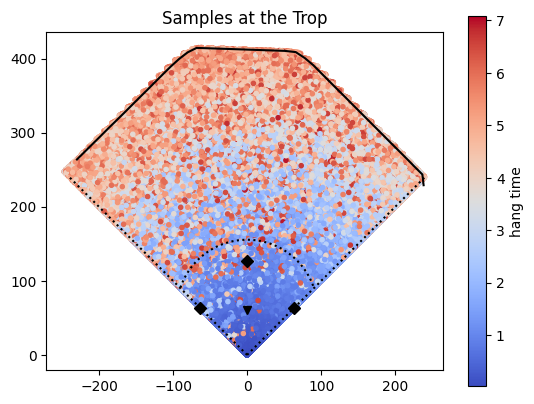

In [0]:
#plot
# plt.scatter(samples.landing_x.values, samples.landing_y.values, c = samples.hangtime.values, marker = '.', cmap = 'coolwarm')
# plt.colorbar(label = 'hang time')
# bases_x = [0, -63.64, 63.64]
# bases_y = [127.27, 63.64, 63.64]
# mound = [0, 60.5]
# circ = np.linspace(-90, 90, 100)
# plt.plot([mound[0]], [mound[1]], 'kv')
# plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
# plt.plot(bases_x, bases_y, 'kD')
# plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
# plt.plot([0,240], [0,240], 'k:')
# plt.plot([0,-240], [0,240], 'k:')
# plt.gca().set_aspect('equal')
# plt.title('Samples at the Trop')
# plt.show()

In [0]:
#memory saving
del hd_net
del la_net
del ev_net
gc.collect()

37002

In [0]:
#more memory saving
samples = samples[['landing_x', 'landing_y', 'launch_speed', 'launch_angle', 'hit_direction', 'hangtime', 'distance', 'matchup_index', 'batter', 'pitcher', 'bat_handR', 'pit_handR', 'xwoba']]
gc.collect()

11280

In [0]:
#triple all the samples since I wasn't able to take as many pitches as I wanted to
samples = pd.concat((samples, samples, samples), ignore_index = True)

#add extra groundballs like we did in the sloan paper
samples['is_gb'] = 0
samples.loc[samples.launch_angle <= 10, 'is_gb'] = 1
gb = samples.loc[samples.is_gb == 1]
fb = samples.loc[samples.is_gb == 0]
gb2 = gb.sample(frac = 2, replace = True)
samples = pd.concat((gb, gb2, fb))
del gb
del fb
del gb2
gc.collect()

36698

## Optimizing

In [0]:
#define the coefficients in the outs models
#### Groundball
gb_int =-2.7808253
gb_angle_diff = -0.1463456
gb_bttf = 5.86696302
gb_bttf2 = -1.31835977

#### Fly ball regression model coefficients
fb_int = -2.16869748
fb_td_slope = 1.50402427

In [0]:
class DataSet(Dataset):
    def __init__(self, x,y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)

        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

#for the linear models, we need the landing coordinates, the hang time, the exit speed, the hit direction

features = ['landing_x', 'landing_y', 'launch_speed', 'hit_direction', 'hangtime', 'distance', 'is_gb', 'matchup_index']

train_x = samples[features].values
train_y = samples.xwoba.values
trainset = DataSet(train_x, train_y)

trainloader = DataLoader(trainset, batch_size = 2048, shuffle = True)

In [0]:
#define a constraint function. Note that the embedding layer will not necessarily have the constraints applied, so we need to apply them before we make fielding recs
def constraint_func(bat_emb, constraint_type = 1):

    #first base constraint: must be within 40 feet from firstbase so he can cover the bag
    _1b = torch.tensor([[63.64, 63.64]]).to(device)
    p1b = bat_emb[:,0:2] - _1b
    _1b_dist = torch.norm(p1b, dim = 1)
    _1b_angle = torch.atan2(p1b[:,0], p1b[:,1])
    _1b_dist2 = _1b_dist.clone()
    #reset dists that are too far
    _1b_dist2[_1b_dist > 40] = 40.
    #reset coordinates by maintaining the same angle with first base but shrinking the distance
    p1bx = _1b_dist2 * torch.sin(_1b_angle) + 63.64
    p1by = _1b_dist2 * torch.cos(_1b_angle) + 63.64

    if constraint_type == 2:
      #shift ban constraint: infielders have to be in dirt and two on either side of second base.
      #That means we need the distance from each fielder to the center of the mound to be less than 95 ft based on this article: https://angelsnation.com/mlb-to-begin-enforcing-length-of-infield-dirt-at-stadiums/2022/10/23/
      #get the coordinates of the infielders relative to the mound
      mound = torch.tensor([[0, 60.5]]).to(device)
      mp3 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1)), dim = 1) - mound
      mp4 = bat_emb[:,2:4] - mound
      mp5 = bat_emb[:,4:6] - mound
      mp6 = bat_emb[:,6:8] - mound

      #get the player angles relative to the mound
      ma3 = torch.atan2(mp3[:,0], mp3[:,1])
      ma4 = torch.atan2(mp4[:,0], mp4[:,1])
      ma5 = torch.atan2(mp5[:,0], mp5[:,1])
      ma6 = torch.atan2(mp6[:,0], mp6[:,1])

      #get the depths relative to the mound. these will need to be less than or equal to 95 in order to stay in the dirt
      md3 = torch.norm(mp3, dim = 1)
      md4 = torch.norm(mp4, dim = 1)
      md5 = torch.norm(mp5, dim = 1)
      md6 = torch.norm(mp6, dim = 1)

      #reset depths greater than 95 to be 95. I think we need to clone these in order for backprop to work, but I'm not sure
      md32 = md3.clone()
      md42 = md4.clone()
      md52 = md5.clone()
      md62 = md6.clone()
      md32[md3 > 95] = 95.
      md42[md4 > 95] = 95.
      md52[md5 > 95] = 95.
      md62[md6 > 95] = 95.

      #reset illegal angles (by the shift ban) to be legal once again we need to clone
      ma32 = ma3.clone()
      ma42 = ma4.clone()
      ma52 = ma5.clone()
      ma62 = ma6.clone()
      ma32[ma3 < 0] = 0.
      ma42[ma4 < 0] = 0.
      ma52[ma5 > 0] = 0.
      ma62[ma6 > 0] = 0.

      #now we recalculate x and y coordinates with the new depth and and angle relative to the mound by converting from polar to cartesian. In baseball coords, x and y are sorta flipped because of the way angles are defined, so x = rsin(theta) and y = rcos(theta)
      x3 = md32 * torch.sin(ma32)
      y3 = md32 * torch.cos(ma32)
      x4 = md42 * torch.sin(ma42)
      y4 = md42 * torch.cos(ma42)
      x5 = md52 * torch.sin(ma52)
      y5 = md52 * torch.cos(ma52)
      x6 = md62 * torch.sin(ma62)
      y6 = md62 * torch.cos(ma62)

      #readjust coords to be relative to plate instead of mound like they were originally. Since the x coordinate is 0 for both the mound and plate, we only need to worry about the y's
      y3 = y3 + 60.5
      y4 = y4 + 60.5
      y5 = y5 + 60.5
      y6 = y6 + 60.5
      #define a new embedding with the constraints adjusted for
      bat_emb2 = torch.cat((x3.unsqueeze(1), y3.unsqueeze(1), x4.unsqueeze(1), y4.unsqueeze(1), x5.unsqueeze(1), y5.unsqueeze(1), x6.unsqueeze(1), y6.unsqueeze(1), bat_emb[:,8:].clone()), dim = 1)

    else:
      #no shift ban
      bat_emb2 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1), bat_emb[:,2:].clone()), dim = 1)

    return bat_emb2

In [0]:
class Optimizer(nn.Module):
    def __init__(self, constraint_type = 1):
        super().__init__()

        self.embed = nn.Embedding(samples.matchup_index.max() + 1, embedding_dim = 14).to(device)

        #initialize the embedding
        default = np.array([71.6, 90, 25.5, 137.7, -67.6, 93, -37.4, 134.9, -124.3, 256.5, 0, 325, 124.3, 256.5])
        self.embed.weight.data = torch.tensor(default, dtype = torch.float32).repeat((samples.matchup_index.max()+1,1)).to(device)

        #the constraint types are 1 and 2. 1 is no constraints except firstbaseman has to be able to cover. 2 is shift ban constraints from 2023
        self.constraint_type = constraint_type

    def forward(self, x):
        batter_idx = x[:,-1].int()
        bat_emb = self.embed(batter_idx)

        #first base constraint: must be within 40 feet from firstbase so he can cover the bag
        _1b = torch.tensor([[63.64, 63.64]]).to(device)
        p1b = bat_emb[:,0:2] - _1b
        _1b_dist = torch.norm(p1b, dim = 1)
        _1b_angle = torch.atan2(p1b[:,0], p1b[:,1])
        _1b_dist2 = _1b_dist.clone()
        #reset dists that are too far
        _1b_dist2[_1b_dist > 40] = 40.
        #reset coordinates by maintaining the same angle with first base but shrinking the distance
        p1bx = _1b_dist2 * torch.sin(_1b_angle) + 63.64
        p1by = _1b_dist2 * torch.cos(_1b_angle) + 63.64

        if self.constraint_type == 2:
          #shift ban constraint: infielders have to be in dirt and two on either side of second base.
          #That means we need the distance from each fielder to the center of the mound to be less than 95 ft based on this article: https://angelsnation.com/mlb-to-begin-enforcing-length-of-infield-dirt-at-stadiums/2022/10/23/
          #get the coordinates of the infielders relative to the mound
          mound = torch.tensor([[0, 60.5]]).to(device)
          mp3 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1)), dim = 1) - mound
          mp4 = bat_emb[:,2:4] - mound
          mp5 = bat_emb[:,4:6] - mound
          mp6 = bat_emb[:,6:8] - mound

          #get the player angles relative to the mound
          ma3 = torch.atan2(mp3[:,0], mp3[:,1])
          ma4 = torch.atan2(mp4[:,0], mp4[:,1])
          ma5 = torch.atan2(mp5[:,0], mp5[:,1])
          ma6 = torch.atan2(mp6[:,0], mp6[:,1])

          #get the depths relative to the mound. these will need to be less than or equal to 95 in order to stay in the dirt
          md3 = torch.norm(mp3, dim = 1)
          md4 = torch.norm(mp4, dim = 1)
          md5 = torch.norm(mp5, dim = 1)
          md6 = torch.norm(mp6, dim = 1)

          #reset depths greater than 95 to be 95. I think we need to clone these in order for backprop to work, but I'm not sure
          md32 = md3.clone()
          md42 = md4.clone()
          md52 = md5.clone()
          md62 = md6.clone()
          md32[md3 > 95] = 95.
          md42[md4 > 95] = 95.
          md52[md5 > 95] = 95.
          md62[md6 > 95] = 95.

          #reset illegal angles (by the shift ban) to be legal once again we need to clone
          ma32 = ma3.clone()
          ma42 = ma4.clone()
          ma52 = ma5.clone()
          ma62 = ma6.clone()
          ma32[ma3 < 0] = 0.
          ma42[ma4 < 0] = 0.
          ma52[ma5 > 0] = 0.
          ma62[ma6 > 0] = 0.

          #now we recalculate x and y coordinates with the new depth and and angle relative to the mound by converting from polar to cartesian. In baseball coords, x and y are sorta flipped because of the way angles are defined, so x = rsin(theta) and y = rcos(theta)
          x3 = md32 * torch.sin(ma32)
          y3 = md32 * torch.cos(ma32)
          x4 = md42 * torch.sin(ma42)
          y4 = md42 * torch.cos(ma42)
          x5 = md52 * torch.sin(ma52)
          y5 = md52 * torch.cos(ma52)
          x6 = md62 * torch.sin(ma62)
          y6 = md62 * torch.cos(ma62)

          #readjust coords to be relative to plate instead of mound like they were originally. Since the x coordinate is 0 for both the mound and plate, we only need to worry about the y's
          y3 = y3 + 60.5
          y4 = y4 + 60.5
          y5 = y5 + 60.5
          y6 = y6 + 60.5
          #define a new embedding with the constraints adjusted for
          bat_emb2 = torch.cat((x3.unsqueeze(1), y3.unsqueeze(1), x4.unsqueeze(1), y4.unsqueeze(1), x5.unsqueeze(1), y5.unsqueeze(1), x6.unsqueeze(1), y6.unsqueeze(1), bat_emb[:,8:].clone()), dim = 1)

        else:
          #no shift ban
          bat_emb2 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1), bat_emb[:,2:].clone()), dim = 1)

        #################################################################################################################################################################################################
        #get fielder depths
        first_depth = torch.norm(bat_emb2[:,:2], dim = 1).unsqueeze(1)
        second_depth = torch.norm(bat_emb2[:,2:4], dim = 1).unsqueeze(1)
        third_depth = torch.norm(bat_emb2[:,4:6], dim = 1).unsqueeze(1)
        ss_depth = torch.norm(bat_emb2[:,6:8], dim = 1).unsqueeze(1)
        lf_depth = torch.norm(bat_emb2[:,8:10], dim = 1).unsqueeze(1)
        cf_depth = torch.norm(bat_emb2[:,10:12], dim = 1).unsqueeze(1)
        rf_depth = torch.norm(bat_emb2[:,12:14], dim = 1).unsqueeze(1)
        depths = torch.cat((first_depth, second_depth, third_depth, ss_depth, lf_depth, cf_depth, rf_depth), dim = -1)

        ##### Flyballs
        # we need the closest fielder to the landing spot
        landing_spot = x[:,:2]
        first_dist = torch.norm(bat_emb2[:,:2] - landing_spot, dim = 1).unsqueeze(1)
        second_dist = torch.norm(bat_emb2[:,2:4] - landing_spot, dim = 1).unsqueeze(1)
        third_dist = torch.norm(bat_emb2[:,4:6] - landing_spot, dim = 1).unsqueeze(1)
        ss_dist = torch.norm(bat_emb2[:,6:8] - landing_spot, dim = 1).unsqueeze(1)
        lf_dist = torch.norm(bat_emb2[:,8:10] - landing_spot, dim = 1).unsqueeze(1)
        cf_dist = torch.norm(bat_emb2[:,10:12] - landing_spot, dim = 1).unsqueeze(1)
        rf_dist = torch.norm(bat_emb2[:,12:14] - landing_spot, dim = 1).unsqueeze(1)
        dists = torch.cat((first_dist, second_dist, third_dist, ss_dist, lf_dist, cf_dist, rf_dist), dim = -1)
        mindist, mindist_index = torch.min(dists, dim = 1)
        #now we need the timediff, which is the time it takes an average runner (27 ft/s) to cover mindist subtracted from the hang time
        timediff = x[:,4] - (mindist / 27)

        #now we can calculate fly ball out probability
        fb_prob_outs = torch.special.expit(fb_int + timediff * fb_td_slope)

        #### Groundballs
        #calculate fielder angles
        a3 = torch.arctan2(bat_emb2[:,0], bat_emb2[:,1]) * 180/np.pi
        a4 = torch.arctan2(bat_emb2[:,2], bat_emb2[:,3]) * 180/np.pi
        a5 = torch.arctan2(bat_emb2[:,4], bat_emb2[:,5]) * 180/np.pi
        a6 = torch.arctan2(bat_emb2[:,6], bat_emb2[:,7]) * 180/np.pi
        a7 = torch.arctan2(bat_emb2[:,8], bat_emb2[:,9]) * 180/np.pi
        a8 = torch.arctan2(bat_emb2[:,10], bat_emb2[:,11]) * 180/np.pi
        a9 = torch.arctan2(bat_emb2[:,12], bat_emb2[:,13]) * 180/np.pi

        #get the angle diffs
        hd = x[:,3]
        ad3 = (a3 -hd).unsqueeze(1)
        ad4 = (a4-hd).unsqueeze(1)
        ad5 = (a5-hd).unsqueeze(1)
        ad6 = (a6-hd).unsqueeze(1)
        ad7 = (a7-hd).unsqueeze(1)
        ad8 = (a8-hd).unsqueeze(1)
        ad9 = (a9-hd).unsqueeze(1)
        angle_diffs = torch.cat((ad3, ad4, ad5, ad6, ad7, ad8, ad9), dim = -1)

        #get the closest infielder by absolute angle dist, so we need to make sure non infielders aren't counted by setting their values really large
        inf_ad3 = ad3.clone()
        inf_ad4 = ad4.clone()
        inf_ad5 = ad5.clone()
        inf_ad6 = ad6.clone()
        inf_ad7 = ad7.clone()
        inf_ad8 = ad8.clone()
        inf_ad9 = ad9.clone()
        inf_ad3[first_depth > 200] = 1000.
        inf_ad4[second_depth > 200] = 1000.
        inf_ad5[third_depth > 200] = 1000.
        inf_ad6[ss_depth > 200] = 1000.
        inf_ad7[lf_depth > 200] = 1000.
        inf_ad8[cf_depth > 200] = 1000.
        inf_ad9[rf_depth > 200] = 1000.
        inf_vals = torch.abs(torch.cat((inf_ad3, inf_ad4, inf_ad5, inf_ad6, inf_ad7, inf_ad8, inf_ad9), dim = -1))
        closest_ifer, closest_ifer_index = torch.min(inf_vals, dim = 1)
        #we need their depth and absolute angle diff
        closest_ifer_depth = depths[torch.arange(depths.size(0)), closest_ifer_index].unsqueeze(1)
        closest_ifer_angle = torch.abs(angle_diffs[torch.arange(depths.size(0)), closest_ifer_index].unsqueeze(1))
        #calcluate the ball time to fielder, depth divided by exit speed in feet per second.
        bttf = closest_ifer_depth.squeeze(1) / (x[:,2] * 1.4667)

        #now we can calculate ground ball out probability using the regression model
        gb_prob_outs = torch.special.expit(gb_int + gb_angle_diff * closest_ifer_angle.squeeze(1) + gb_bttf * bttf + gb_bttf2 * bttf**2)

        #the final out probability depends on if it is a ground ball or fly ball
        is_gb = x[:,6]
        return is_gb * gb_prob_outs + (1-is_gb) * fb_prob_outs

In [0]:
#minimize woba loss function
def minimize_woba(output, target):
    #output would obviously be the output of the net, which is an out probability. Target is the woba of a hit, so we take 1-out prob and multiply that by target, and that gives xwoba of a non out, and we want to minimize this
    return torch.mean((1-output) * target)*1000

In [0]:
#training parameters
learning_rate = 1
epochs = 5
loss_fn = minimize_woba

In [0]:
#shift ban
opt1 = Optimizer(2).to(device)
optimizer = torch.optim.SGD(opt1.parameters(), lr = learning_rate, momentum = 0.9)
train_losses = []

#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    for batch, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        outputs = opt1(x)
        #calculate loss
        loss = loss_fn(outputs, y)
        loss_val += loss.item()
        #backprop
        loss.backward()
        optimizer.step()


    train_losses.append(loss_val / len(trainloader))

    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

plt.plot(train_losses)
plt.show()

epoch : 1/5, loss = 250.369544


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:730)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:448)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:448)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

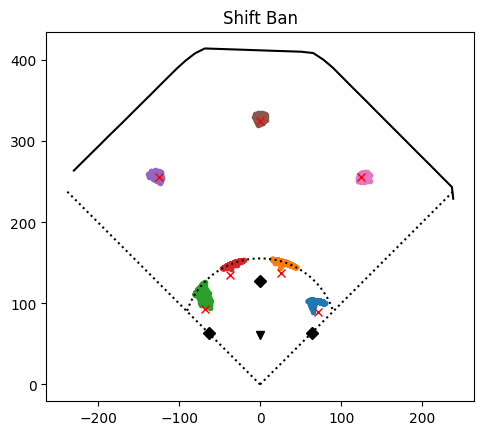

In [0]:
#plot the results
batter_weights1 = pd.DataFrame({'matchup_index': [i for i in range(samples.matchup_index.max()+1)]})
bat_embeddings = opt1.embed.weight.data
constrained = constraint_func(bat_embeddings, 2)
batter_weights1[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9']] = constrained.detach().cpu().numpy()

standard_pos = np.array([71.6, 90, 25.5, 137.7, -67.6, 93, -37.4, 134.9, -124.3, 256.5, 0, 325, 124.3, 256.5])
bases_x = [0, -63.64, 63.64]
bases_y = [127.27, 63.64, 63.64]
circ = np.linspace(-90, 90, 100)
mound = [0, 60.5]
for i in range(7):
    plt.plot(batter_weights1['x' + str(i + 3)], batter_weights1['y' + str(i+3)], '.')
    plt.plot([standard_pos[2*i]], [standard_pos[2*i+1]], 'rx')
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.gca().set_aspect('equal')
plt.title('Shift Ban')
plt.show()

In [0]:
#save the positioning
batter_weights1 = batter_weights1.merge(matchup_df[['batter', 'pitcher', 'bat_handR', 'matchup_index']], on = 'matchup_index')

In [0]:
batter_weights1.to_csv(f'./results/{team}_pitchers.csv', index=False)